# Introduction to "Regularization"

The concept of regularization is adding an additional "penalty" on the size of coefficients to the minimization of sum of squared errors in standard regression.

In other words, there are additional components to the loss function, so the minimization becomes a balance between these components. 

The two most common types of regularization are the **"Lasso"**, **"Ridge"**, and the **Elastic Net**. We will be examining the math behind how they work and the effect they have on model fits.

---

### Refresher: the least squares loss function

You've become familiar at this point with the least squares loss function. Vanilla regression minimizes the residual sum of squares (RSS) to fit the data:

### $$ \text{minimize}\; RSS = \sum_{i=1}^n (y_i - \hat{y}_i) = \sum_{i=1}^n \left(y_i - (\beta_0 + \beta_i x_i)\right) $$

Where our model predictions for $y$ are based on the sum of the $beta_0$ intercept and the products of $\beta_i$ with $x_i$.

---

### Ridge regression

The Ridge regression adds an additional thing to the loss function: the sum of the squared (non-intercept!) $\beta$ values:

### $$ \text{minimize}\; RSS = \sum_{i=1}^n \left(y_i - (\beta_0 + \beta_i x_i)\right) + \lambda_2\sum_{i=1}^n \beta_i^2$$

What are these new components?

$\beta_i^2$ is the squared coefficient for variable $x_i$.

$\sum_{i=1}^n \beta_i^2$ is the sum of these squared coefficients for every variable we have in our model. This does **not** include the intercept $\beta_0$.

$\lambda_2$ is a constant for the _strength_ of the regularization parameter. The higher this value, the greater the impact of this new component in the loss function. If this were zero, then we would revert back to just the least squares loss function. If this were, say, a billion, then the residual sum of squares component would have a much smaller effect on the loss/cost than the regularization term.

---

### Lasso regression

The Lasso regression takes a different approach. Instead of adding the sum of _squared_ $\beta$ coefficients to the RSS, it adds the sum of the _absolute value_ of the $\beta$ coefficients:

### $$ \text{minimize}\; RSS = \sum_{i=1}^n \left(y_i - (\beta_0 + \beta_i x_i)\right) + \lambda_1\sum_{i=1}^n |\beta_i|$$

$|\beta_i|$ is the absolute value of the $\beta$ coefficient for variable $x_i$

$\lambda_1$ is again the strength of the regularization penalty component in the loss function. In lasso the lambda is denoted with a 1, in ridge the lambda is denoted with a 2. 

---

### Elastic Net

Elastic Net is a combination of both the Lasso and the Ridge regularizations. It adds both penalties to the loss function:

### $$ \text{minimize}\; RSS = \sum_{i=1}^n \left(y_i - (\beta_0 + \beta_i x_i)\right) + \lambda_1\sum_{i=1}^n |\beta_i| + \lambda_2\sum_{i=1}^n \beta_i^2$$

In the elastic net, the effect of the Ridge vs. the Lasso is balanced by the two lambda parameters. 

---

### So when do you use each? What is the effect of regularization?

This is what we will investigate in this lesson. We will be using a dataset on wine quality.

The important aspect of this data, which is a reason why we might choose to use regularization, is that there is **multicollinearity** in the data.

The term multicollinearity means that there are high correlations between predictor variables in your model. This is a problem because the regression has no good way to distinguish between the effect of either on the target variable. You can end up with meaningless or absurd coefficients if you don't address this problem.

The Lasso and Elastic Net are also very useful for when you have redundant or unimportant variables. If you have 1000 variables in a dataset the Lasso can perform "feature selection" automatically for you

---

### 1. Load standard packages

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

---

### 2. Import data

Load in the wine dataset with pandas. 

This version has red and white wines concatenated together and tagged with a binary 1,0 indicator (1 is red wine). There are many other variables purportedly related to the rated quality of the wine.

In [38]:
wine = pd.read_csv('/Users/tlee010/desktop/DSI-SF-2-timdavidlee/datasets/wine_quality/winequality_merged.csv')

# replace spaces in column names and convert all columns to lowercase:
wine.columns = [x.lower().replace(' ','_') for x in wine.columns]

In [39]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


---

### 3. Normalize the predictor columns

With the Lasso and Ridge it is neccessary to normalize the predictor columns before constructing the models, even the dummy coded categorical variables. 

Below we define our target variable and then normalize the columns that are not the target.

### Why is normalization of predictors required?

Recall the equations for the Ridge and Lasso penalties:

### $$ \text{Ridge penalty}\; = \lambda_2\sum_{i=1}^n \beta_i^2$$

### $$ \text{Lasso penalty}\; = \lambda_2\sum_{i=1}^n |\beta_i|$$

**How are the $\beta$ coefficients affected by the mean and variance of your variables?**

If the mean and variance of your $x$ predictors are different, their respective $\beta$ coefficients _scale with the mean and variance of the predictors **regardless of their explanatory power.**_

This means that if one of your $x$ variables, for example the price of a home, will have a much smaller $\beta$ value than say the number of bedrooms in a house – just because the scale of the two variables are so different.

The Ridge and Lasso penalties are agnostic to the mean and variance of your predictors. All they "care about" are the values of the coefficients. If one of your coefficients is much larger than any of the others, it will dominate the effect of the penalty on your minimization!



In [40]:
# Choose a target/dependent variable that we will predict
target = 'quality'

In [41]:
# select all the columns that are not the target
nc = [x for x in wine.columns if x != target]

# Using the .ix indexing syntax, subtract mean and divide by standard deviation for all predictor columns.
#
# Remember: .ix indexing notation works like: data.ix[row_indices, column_indices]
# .ix is able to take a mix of boolean, number, or string specifications, which is useful.
#
# By subtracting the mean and dividing by the standard devation, the normalization procedure is putting 
# all of the predictor variables on the same scale (distributions with mean == 0 and standard deviation == 1)
wine.ix[:, nc] = (wine.ix[:, nc] - wine.ix[:, nc].mean()) / wine.ix[:, nc].std()

In [42]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,5,1.750055
1,0.451001,3.281982,-2.192664,-0.597594,1.197883,-0.311296,-0.862402,0.701432,-0.115064,0.999502,-0.580023,5,1.750055
2,0.451001,2.553104,-1.917405,-0.660648,1.026618,-0.874695,-1.092402,0.768128,0.258100,0.797897,-0.580023,5,1.750055
3,3.073580,-0.362411,1.660957,-0.744721,0.541370,-0.762016,-0.986248,1.101609,-0.363840,0.327485,-0.580023,6,1.750055
4,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,5,1.750055


---

### 4. Check out the correlation matrix

Correlation matrix is useful to get some intuition right away for the relationships (or lack thereof) between all of our variables.

Print out the numeric correlation. Also make a heatmap with seaborn.

In [43]:
wine_corr = wine.corr()
wine_corr

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
fixed_acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile_acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric_acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual_sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
ph,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218


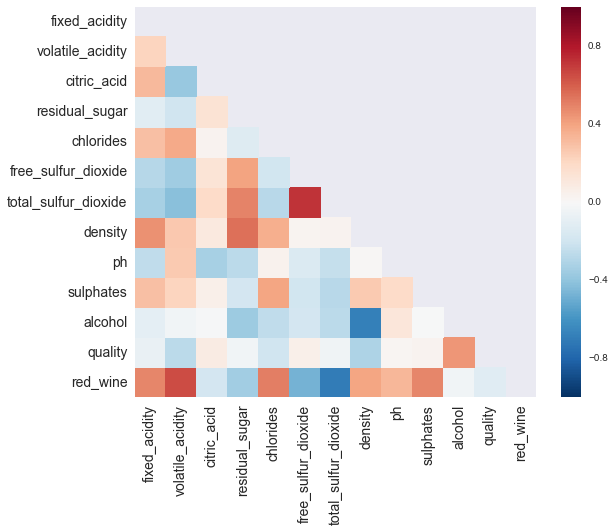

In [44]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(wine_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

---

### 5. Make X and Y data

Import patsy so we can use the formula syntax.

We will be making two X, Y datasets. 

1. The first is going to just be all the variables added together.
2. The second will 'multiply' the variables together. This means that every possible interaction between variables will be modeled, which should overfit the target quite a bit!


In [45]:
import patsy

# Get the non-target cols with a simple list comprehension
non_target_cols = [c for c in wine.columns if c != target]

# Use some string adding and joining to make the simple model formula:
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print formula_simple

# Make the complex formula:
formula_complex = target + ' ~ (' + ' + '.join(non_target_cols) + ')**2 -1'
print formula_complex

# Create the X and Y pairs for both!
Y, X = patsy.dmatrices(formula_simple, data=wine)
Yoverfit, Xoverfit = patsy.dmatrices(formula_complex, data=wine)


quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine -1
quality ~ (fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine)**2 -1


Look at how the shapes of the X matrices differ. You can see taht the Xoverfit has a ton of columns due to the creation of all possible interactions.

In [46]:
print X.shape
print Xoverfit.shape

(6497, 12)
(6497, 78)


Assign the feature names for the simple and complex models to variables. We can use the `.design_info.column_names` attribute of these patsy matrix objects.

You can print out the complex feature names if you feel like it. There are a ton.

In [47]:
simple_feature_names = X.design_info.column_names
complex_feature_names = Xoverfit.design_info.column_names

---

### 6. Visualize the Ridge and Lasso regularization on coefficients

We will only do this for the simple data since the model that will overfit has too many coefficients to see anything properly on a graph.

---

### 6.1 Visualizing the Ridge

Import the `Ridge` model class from sklearn:

In [48]:
from sklearn.linear_model import Ridge

Here I write a function that iterates over a series of different alpha regularization parameters. The alpha is related to the lambda value that multiples the square of betas from the equation (though it may not be exactly the same numerically – regardless, increasing the alpha increases the regularization of the ridge on the coefficients).

In [49]:
def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list (first element of the .coef_ attribute)
        coefs.append(ridge_reg.coef_[0])
        
    return coefs

Alpha values for the ridge are best visualized on a logarithmic "magnitude" scale. Essentially the effect does not increase linearly so much as by the increase in orders of magnitude. You will see that this is different for the lasso (and is related to the fact that for the Ridge the beta coefficients are squared, rather than just the absolute value like in the Lasso).

In [50]:
# np.logspace gives us points between specified orders of magnitude on a logarithmic scale. It is base 10.
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

---

Below I've written a plotting function that will:

 - Plot the effect of changing alpha on the coefficient size on a **path** graph
 - Plot the effect of changing alpha on the coefficient size on a **bar** graph
 
Each one gives informative information. It's just two different ways of visualizing the same thing. The chart is interactive so you can play around with the values of alpha across the specified range above.

In [51]:
# The cycler package lets us "cycle" throug colors.
# Just another thing i had to look up on stackoverflow. That's my life.
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors)
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()


Load the ipython widgets so we can make this plotting function interactive!

In [52]:
from ipywidgets import *
from IPython.display import display

The function and `interact` from ipywidgets lets me take some specified alphas that we have already calculated the coefficients for and plot them out.

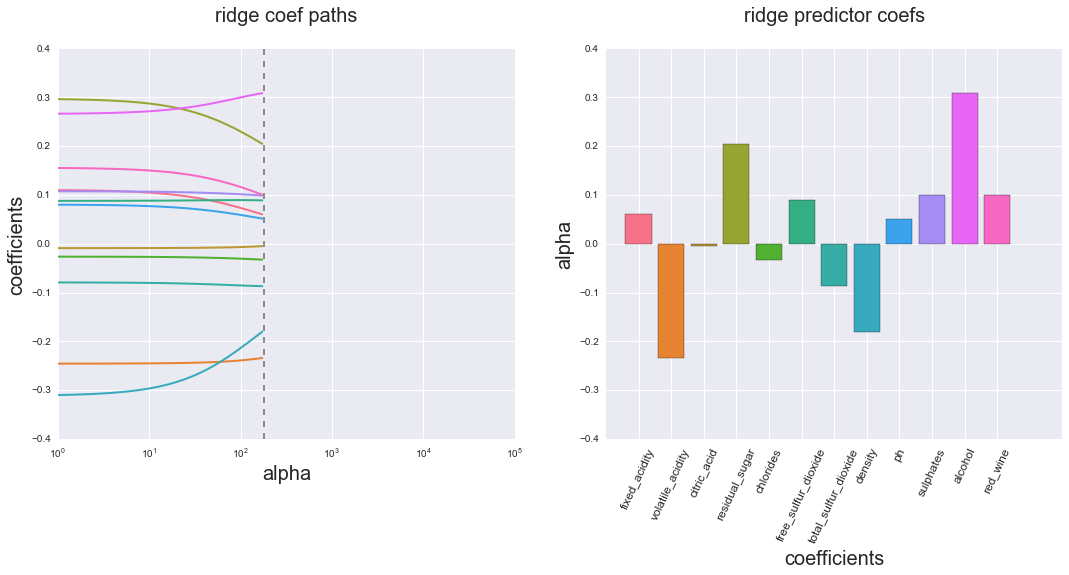

In [58]:
def ridge_plot_runner(log_of_alpha=0):
    coef_plotter(r_alphas, r_coefs, simple_feature_names, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.0,5.0,0.05))

---

### 6.2 Visualizing the Lasso

Now we do the same thing as above but for the Lasso. You will be able to see how the coefficients change differently for both.

In [54]:
from sklearn.linear_model import Lasso

In [55]:
# This is the same as the ridge coefficient by alpha calculator
def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs


Alphas for the Lasso tend to effect regularization linearly rather than by orders of magnitude like in the ridge. A linear series of alphas is sufficient. Don't worry about the warning for Lasso at alpha 0.

In [56]:
l_alphas = np.arange(0, 0.15, 0.0025)
l_coefs = lasso_coefs(X, Y, l_alphas)

/Users/tlee010/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


Run the same plotting function above, but now with the calculated coefficients by alpha for the Lasso.

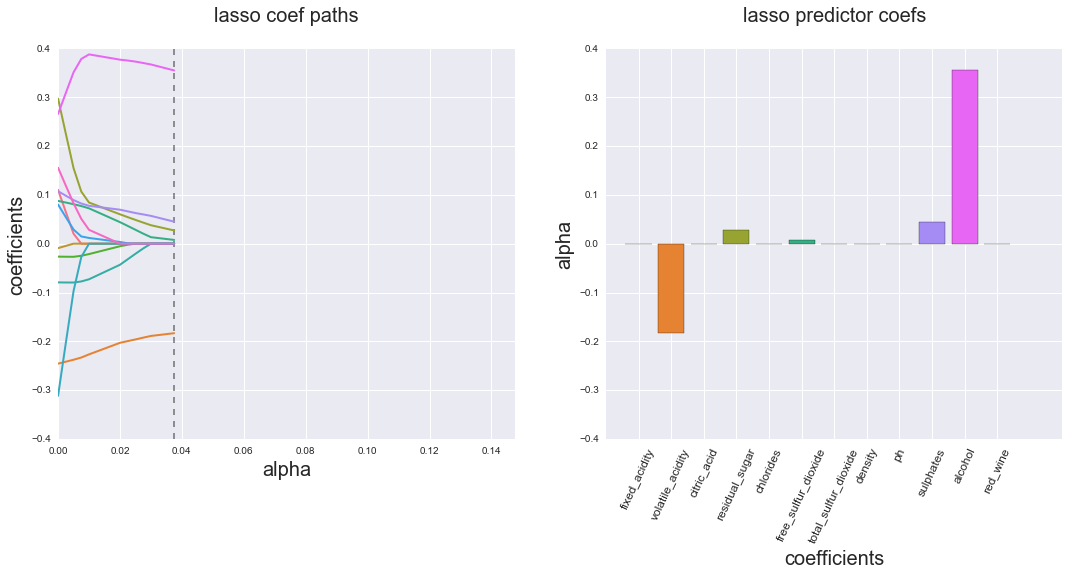

In [57]:
def lasso_plot_runner(alpha=0):
    coef_plotter(l_alphas, l_coefs, simple_feature_names, alpha, regtype='lasso')

interact(lasso_plot_runner, alpha=(0.0,0.2,0.0025))

--- 

### Visualizing the Elastic Net

Recall that the Elastic Net combines the Ridge and Lasso penalties.

Elastic Net has two parameters:

    alpha: the regularization strength
    l1_ratio: the amount of L1 vs L2 penalty. An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso


In [28]:
from sklearn.linear_model import ElasticNet

Calculate the coefficients with both alpha values and an l1_ratio of 0.05. Lasso can "overpower" the Ridge penalty in some datasets, and so rather than an equal balance I'm just adding a little bit of Lasso in.

In [60]:
# This is the same as the ridge coefficient by alpha calculator
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    enet_reg = ElasticNet()
    for a in alphas:
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        coefs.append(enet_reg.coef_)
        
    return coefs

In [61]:
enet_alphas = np.arange(0, 1.0, 0.005)
enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

/Users/tlee010/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


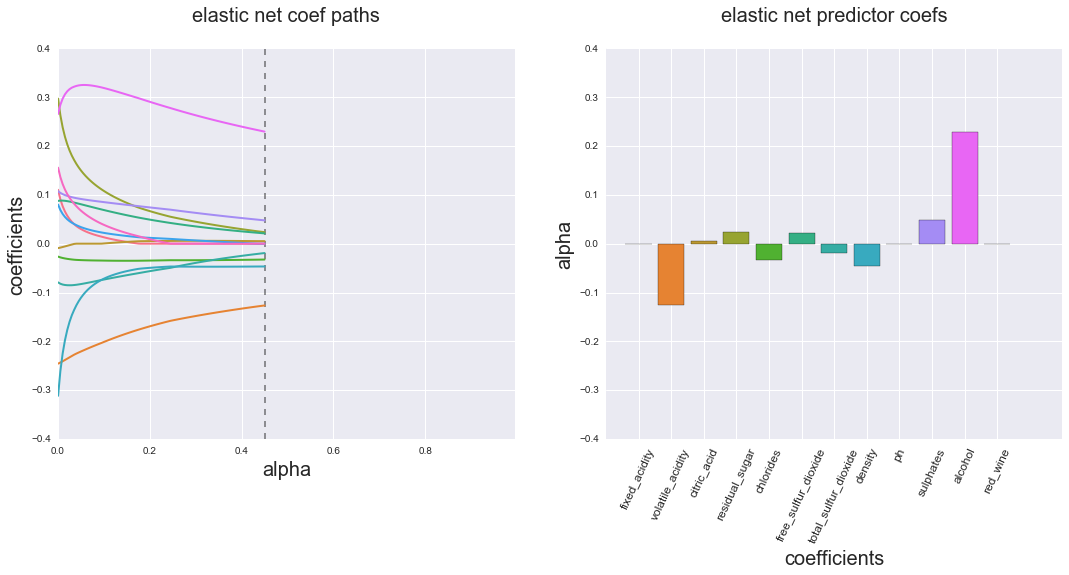

In [62]:
def enet_plot_runner(alpha=0):
    coef_plotter(enet_alphas, enet_coefs, simple_feature_names, alpha, regtype='elastic net')

interact(enet_plot_runner, alpha=(0.0,1.0,0.005))

---

### 7. Model performance of the Ridge, Lasso and Elastic Net on the simple data

Let's check out how the penalties affect the performance of our models.

Load in the KFold crossvalidation function from sklearn. We'll make five folds.

In [32]:
from sklearn.cross_validation import KFold
kfolds = KFold(wine.shape[0], n_folds=5)

For the Ridge, Lasso, and Elastic Net, iterate through their alphas and using the cross-validation folds calculate the average R2 at each regularization level:

In [33]:
def ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, e_alphas, kfolds, verbose=False):
    
    # lists to track mean R2s per alpha
    ridge_rsq = []
    lasso_rsq = []
    enet_rsq = []

    # initialize models
    lasso = Lasso()
    ridge = Ridge()
    enet = ElasticNet()

    print 'Lasso...'
    # iterate through Lasso alphas
    for la in l_alphas:
        
        if verbose: print la
        
        # set the current alpha to the model
        lasso.set_params(alpha=la)
        
        # keep track of fold R2s
        rsqs = []
        
        # iterate through the folds. Each iteration returns the training and
        # testing indices
        for traini, testi in kfolds:
            
            # run the current model with the subset training X and Y
            lasso.fit(X[traini], Y[traini])
            
            # append the R2 on the test set to the tracker
            rsqs.append(lasso.score(X[testi], Y[testi]))
            
        # append the mean of the R2s for this alpha to the R2 by alpha list
        lasso_rsq.append(np.mean(rsqs))

    print 'Ridge...'
    # Do the same process as above for ridge...
    for ra in r_alphas:
        
        if verbose: print ra
        
        ridge.set_params(alpha=ra)
        rsqs = []
        for traini, testi in kfolds:
            ridge.fit(X[traini], Y[traini])
            rsqs.append(ridge.score(X[testi], Y[testi]))
        ridge_rsq.append(np.mean(rsqs))
        
    print 'ElasticNet...'
    # Do the same process as above for ridge...
    for ea in e_alphas:
        
        if verbose: print ea
        
        enet.set_params(alpha=ea, l1_ratio=0.5)
        rsqs = []
        for traini, testi in kfolds:
            enet.fit(X[traini], Y[traini])
            rsqs.append(enet.score(X[testi], Y[testi]))
        enet_rsq.append(np.mean(rsqs))
        
    from sklearn.linear_model import LinearRegression
    
    linreg_rsq = []
    linreg = LinearRegression()
    for traini, testi in kfolds:
        linreg.fit(X[traini], Y[traini])
        linreg_rsq.append(linreg.score(X[testi], Y[[testi]]))
        
    linreg_rsq = np.mean(linreg_rsq)
        
    return ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq
    
# Get the ridge and lasso cross-validated R2s:
ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq = ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, enet_alphas, kfolds)


Lasso...


/Users/tlee010/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:30: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


Ridge...
ElasticNet...


/Users/tlee010/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:60: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


---

Below we have a new plotting function that will track the performance of the model as the alphas increase, as measured by the mean R2s across cross-validation folds. Remember that R2 is a measure of how much variance in the target/dependent variable is explained by our predictor variables.

In [34]:
def rsq_plotter(ridge_alphas, ridge_to_alpha, ridge_rsq,
                lasso_alphas, lasso_to_alpha, lasso_rsq,
                enet_alphas, enet_to_alpha, enet_rsq,
                linreg_rsq):
    
    
    # Find the overall minimum and maximum alpha values for
    # the Ridge and Lasso to fix the plot axes:
    ridge_amin = np.min(ridge_alphas)
    ridge_amax = np.max(ridge_alphas)
    
    lasso_amin = np.min(lasso_alphas)
    lasso_amax = np.max(lasso_alphas)
    
    enet_amin = np.min(enet_alphas)
    enet_amax = np.max(enet_alphas)
    
    # Subet the models' alphas and rsqs according to the currently set
    # alpha limits for each (passed in from the interactive sliders)
    ridge_alphas = [a for a in ridge_alphas if a <= ridge_to_alpha]
    ridge_rsq = ridge_rsq[0:len(ridge_alphas)]
    
    lasso_alphas = [a for a in lasso_alphas if a <= lasso_to_alpha]
    lasso_rsq = lasso_rsq[0:len(lasso_alphas)]
    
    enet_alphas = [a for a in enet_alphas if a <= enet_to_alpha]
    enet_rsq = enet_rsq[0:len(enet_alphas)]
    
    # Get some unique colors out for the Ridge R2 line, Lasso R2 line,
    # Enet R2, and the 'max R2 achieved' line.
    colors = sns.xkcd_palette(['windows blue', 'amber', 'dark red', 'faded green'])

    # We will again be plotting two axes on the same figure:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # The first subplot axes is for the ridge
    ax1 = fig.add_subplot(131)
    
    # Plot a vertical line indicating the current alpha selected
    ax1.axvline(ridge_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot a horizontal line for the vanilla linear regression R^2
    ax1.axhline(linreg_rsq, lw=2, c=colors[2], alpha=0.8)
    
    # Plot the line tracking R2s by alpha values
    ax1.plot(ridge_alphas, ridge_rsq, lw=3, c=colors[0])
    
    # Add the axis labels
    ax1.set_xlabel('ridge alpha', fontsize=20)
    ax1.set_ylabel('ridge CV R2', fontsize=20)
    
    # Set x-axis to logarithmic scale
    ax1.set_xscale('log')
    
    # Fix the axes in place
    ax1.set_xlim([ridge_amin, ridge_amax])
    ax1.set_ylim([-0.05, 1])
    
    # set the title for the axes;
    ax1.set_title('ridge cross-val performance\n', fontsize=20)
    
    
    # Now do all of this as above for the Lasso!
    ax2 = fig.add_subplot(132)
    ax2.axvline(lasso_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax2.axhline(linreg_rsq, lw=2, c=colors[2], alpha=0.8)
    
    ax2.plot(lasso_alphas, lasso_rsq, lw=3, c=colors[0])
    
    ax2.set_xlabel('lasso alpha', fontsize=20)
    ax2.set_ylabel('lasso CV R2', fontsize=20)
    ax2.set_xlim([lasso_amin, lasso_amax])
    ax2.set_ylim([-0.05, 1])
        
    ax2.set_title('lasso cross-val performance\n', fontsize=20)
    
    
    # And ElasticNet:
    ax3 = fig.add_subplot(133)
    ax3.axvline(enet_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax3.axhline(linreg_rsq, lw=2, c=colors[3], alpha=0.8)
    
    ax3.plot(enet_alphas, enet_rsq, lw=3, c=colors[0])
    
    ax3.set_xlabel('enet alpha', fontsize=20)
    ax3.set_ylabel('enet CV R2', fontsize=20)
    ax3.set_xlim([enet_amin, enet_amax])
    ax3.set_ylim([-0.05, 1])
        
    ax3.set_title('enet cross-val performance\n', fontsize=20)
    
    plt.show()

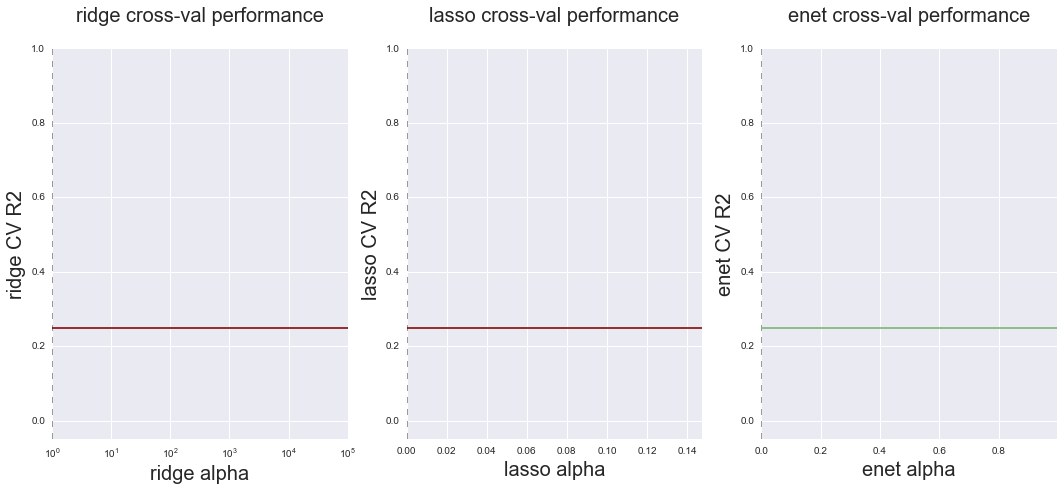

In [35]:
# We have our new widget where you can change both the Ridge and Lasso alphas to see how they compare:

def rsq_plot_pipe(ra, la, ea):
    rsq_plotter(r_alphas, 10**ra, ridge_rsq, l_alphas, la, lasso_rsq, enet_alphas, ea, enet_rsq, linreg_rsq)
    
w = widgets.interactive(rsq_plot_pipe, 
                        ra=widgets.FloatSlider(value=0, min=0., max=5., step=0.05, description='Ridge log10(alpha):'),
                        la=widgets.FloatSlider(value=0, min=0., max=0.2, step=0.0025, description='Lasso alpha:'),
                        ea=widgets.FloatSlider(value=0, min=0., max=1.0, step=0.005, description='Enet alpha:')
)

display(w)

---

### 8. Model performance on the complex data

Let's see what happens when we do this for the complex data that is designed to overfit.

[This function takes a long time to run by comparison, as you might expect.]

In [36]:
overfit_ridge_rsq, overfit_lasso_rsq, overfit_enet_rsq, overfit_linreg_rsq = ridge_lasso_cv_rsq(Xoverfit, Yoverfit, 
                                                                                        r_alphas, l_alphas, 
                                                                                        enet_alphas, kfolds, 
                                                                                        verbose=True)


Lasso...
0.0


/Users/tlee010/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:30: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


0.0025
0.005
0.0075
0.01
0.0125
0.015
0.0175
0.02
0.0225
0.025
0.0275
0.03
0.0325
0.035
0.0375
0.04
0.0425
0.045
0.0475
0.05
0.0525
0.055
0.0575
0.06
0.0625
0.065
0.0675
0.07
0.0725
0.075
0.0775
0.08
0.0825
0.085
0.0875
0.09
0.0925
0.095
0.0975
0.1
0.1025
0.105
0.1075
0.11
0.1125
0.115
0.1175
0.12
0.1225
0.125
0.1275
0.13
0.1325
0.135
0.1375
0.14
0.1425
0.145
0.1475
Ridge...
1.0
1.05956017928
1.12266777351
1.18953406737
1.26038292968
1.33545156293
1.41499129743
1.49926843279
1.58856512943
1.68318035333
1.78343087693
1.88965233969
2.00220037182
2.12145178491
2.24780583355
2.38168555198
2.52353917043
2.67384161584
2.83309610184
3.00183581358
3.18062569279
3.37006432927
3.5707859649
3.78346261713
4.0088063289
4.24757155254
4.5005576757
4.76861169771
5.05263106534
5.35356667741
5.67242606849
6.01027678207
6.36824994472
6.74754405311
7.1494289866
7.57525025877
8.02643352226
8.5044893418
9.01101825167
9.54771611421
10.1163797977
10.7189131921
11.3573335834
12.0337784078
12.7505124071
13.5099

/Users/tlee010/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:60: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


KeyboardInterrupt: 

In [ ]:
print 'Linear Regression R^2:', overfit_linreg_rsq
print 'Ridge best R^2:', np.max(overfit_ridge_rsq)
print 'Lasso best R^2:', np.max(overfit_lasso_rsq)
print 'ElasticNet best R^2:', np.max(overfit_enet_rsq)